## 1. Import Libraries / Dataset

In [119]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
from pickle import dump, load
import glob
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import imagesize
import time

import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


from keras.models import Model
import os
import collections

from tensorflow.keras.utils import plot_model
from keras.layers.merge import add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, GRU, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

import keras

In [70]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [71]:
pickle_file = 'drive/MyDrive/set_4.pkl'
images_path = 'drive/MyDrive/Image_captioning_Dataset/Flicker8k_Dataset'
google_test_image = 'drive/MyDrive/Image_captioning_Dataset/Flicker8k_Dataset/test/test_image1.jpg'

In [72]:
# Read the data from the pickle file
with open(pickle_file, 'rb') as fid:
     image_caption_data = pickle.load(fid)

In [73]:
## Dataframe created based on the pickle file
image_caption_info_df = pd.DataFrame(columns=['image_name', 'caption_id', 'image_caption'])

In [74]:
for line in image_caption_data:
  line = line.strip()
  image_row = [(line.split('\t'))[0].split('#')[0], (line.split('\t'))[0].split('#')[1], (line.split('\t'))[1].strip('.')]
  image_row_dict = {'image_name' : (line.split('\t'))[0].split('#')[0], 'caption_id' : (line.split('\t'))[0].split('#')[1], 'image_caption' : (line.split('\t'))[1].strip('.')}
  image_caption_info_df = image_caption_info_df.append(image_row_dict, ignore_index=True)

In [75]:
image_caption_info_df.head(10)

,image_name,caption_id,image_caption
0,3312779887_7682db7827.jpg,4,A snowboarder do a trick off of a yellow pyramid
1,2766926202_4201bf2bf9.jpg,2,Two man be play with glow stick and sparkler
2,244760301_5809214866.jpg,4,Several hiker walk along a rocky path
3,97105139_fae46fe8ef.jpg,4,Two person with head covering stand in a sandy...
4,2646046871_c3a5dbb971.jpg,3,A child jump in the air with his or her shirt ...
5,3122606953_a979dd3d33.jpg,1,Two black dog walk through the snow
6,3457604528_302396c08c.jpg,3,A child be run through the grassy field
7,2745663684_650f84e1e6.jpg,4,a young man skateboard on a street wear a blac...
8,3308997740_91765ecdcc.jpg,0,A girl with a beanie stand in front of a windo...
9,2619454551_c4bb726a85.jpg,0,A bright colored bird and a small dog


In [76]:
# Removing file names with *.jpg.1 from pickle file data's dataframe
image_caption_info_df = image_caption_info_df[image_caption_info_df['image_name'].str.contains(".jpg.1")==False]

## 2.	Data	Visualization	and	augmentation

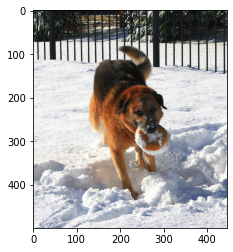

A dog with a Frisbee in the snow 
 


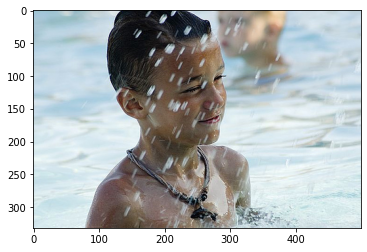

A young boy with a necklace on in the water 
 


In [77]:
# from PIL import Image
# import imagesize
# import matplotlib.image as mpimg

random_list = random.sample(range(1,25000), 2)
for i in random_list:
  img = mpimg.imread(images_path + '/' + image_caption_info_df.iloc[i]['image_name'])
  plt.imshow(img)
  plt.show()
  print(image_caption_info_df.iloc[i]['image_caption'])
  print(' ')

In [78]:
# Creating the List of images in the dataset folder
list_of_images = []
for i in image_caption_info_df['image_name']:
  path = images_path+'/'+i
  if path in list_of_images:
    continue
  else:
    list_of_images.append(path)

print(len(list_of_images))

8019


## 3. Model Building

In [79]:
## Using Pretrained	Resnet-50 model	trained	on ImageNet dataset as base model
base_model = ResNet50(weights='imagenet', include_top=True)

In [80]:
# from keras.models import Model
last = base_model.layers[-2].output
model_emb = Model(inputs = base_model.input, outputs = last)
model_emb.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Feature Extraction

In [81]:
# Limiting to 1500 images for extracting the features as choosing more images causing colab environment to crash while array manipulation.

images_features = {}
count = 0
for i in list_of_images:
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))

  img = img.reshape(1, 224, 224, 3)
  pred = model_emb.predict(img).reshape(2048,)

  im_name = i.split('/')[-1]
  img_name = im_name
  images_features[img_name] = pred

  count += 1
  limit = 1500
  if count > limit:
    break
  elif count % 50 == 0:
    print('Count of Images processed : ', count)
print("Extraction Completed")

Count of Images processed :  50
Count of Images processed :  100
Count of Images processed :  150
Count of Images processed :  200
Count of Images processed :  250
Count of Images processed :  300
Count of Images processed :  350
Count of Images processed :  400
Count of Images processed :  450
Count of Images processed :  500
Count of Images processed :  550
Count of Images processed :  600
Count of Images processed :  650
Count of Images processed :  700
Count of Images processed :  750
Count of Images processed :  800
Count of Images processed :  850
Count of Images processed :  900
Count of Images processed :  950
Count of Images processed :  1000
Count of Images processed :  1050
Count of Images processed :  1100
Count of Images processed :  1150
Count of Images processed :  1200
Count of Images processed :  1250
Count of Images processed :  1300
Count of Images processed :  1350
Count of Images processed :  1400
Count of Images processed :  1450
Count of Images processed :  1500


In [82]:
# Preparing Image name - Captions Dictionary using collections.
#import collections

# Mapping  all "Captions" to it's respective "Image Name".
captions_dict = collections.defaultdict(list)

for file_name in image_caption_info_df['image_name'].unique():
  if file_name in list(images_features.keys()):
    image_path = file_name
    df = image_caption_info_df.loc[image_caption_info_df['image_name'] == file_name]
    for ind in df.index:
      caption = df['image_caption'][ind]
      captions_dict[image_path].append(caption)

In [83]:
len(captions_dict)

1501

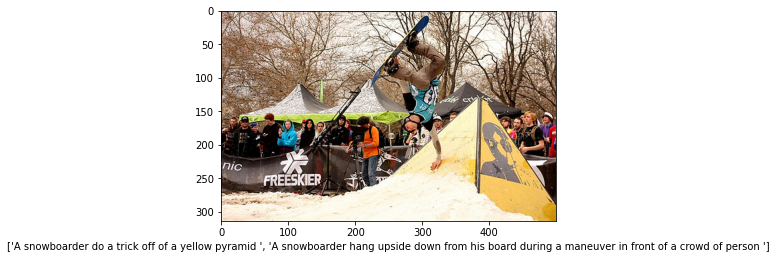

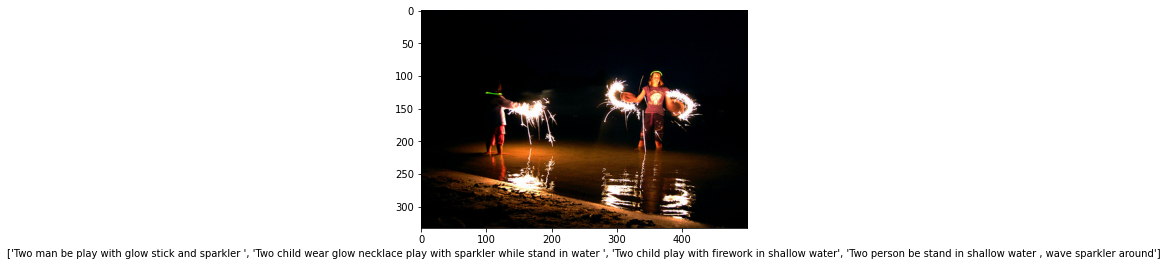

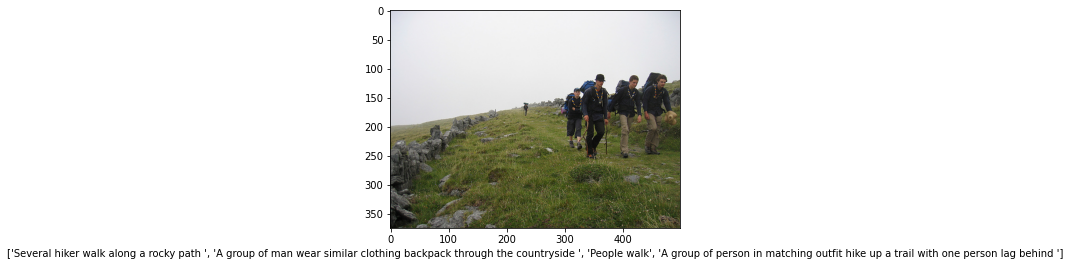

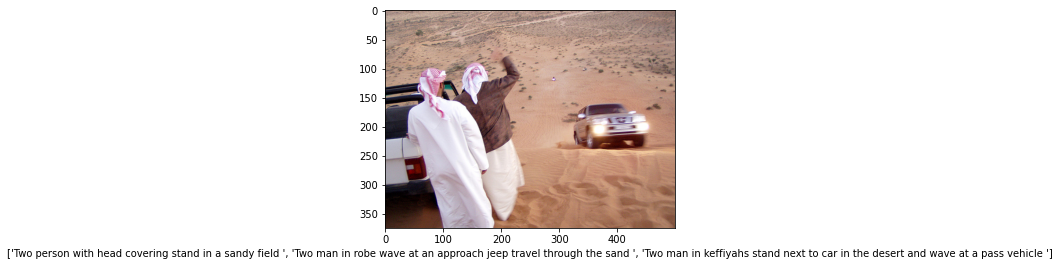

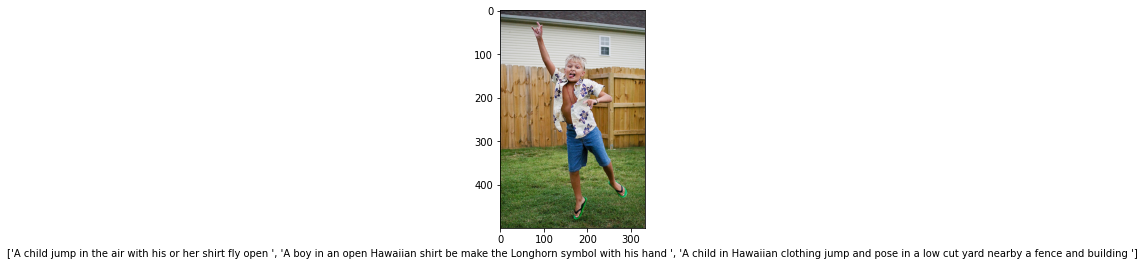

In [84]:
## Sample Visualization of Images from dictionary along with it's captions.
# import matplotlib.pyplot as plt
for i in range(5):
  plt.figure()
  img_name = list_of_images[i]
  img = mpimg.imread(list_of_images[i])
  plt.xlabel(captions_dict[img_name.split('/')[-1]])
  plt.imshow(img)
  plt.show()

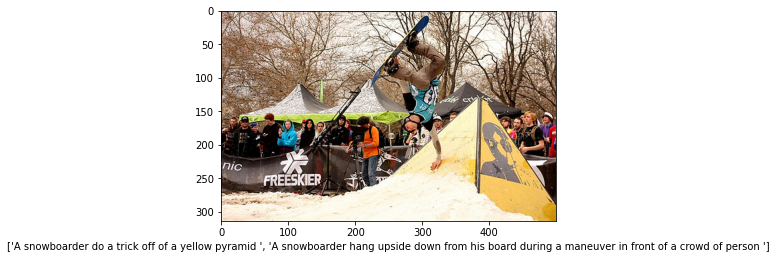

In [85]:
## Sample Visualization of Images from dictionary along with it's captions based on the 'feature'

for file_name in images_features.keys():
  plt.figure()
  img_name = images_path +'/'+ file_name
  img = mpimg.imread(img_name)
  plt.xlabel(captions_dict[img_name.split('/')[-1]])
  plt.imshow(img)
  plt.show()
  break

In [86]:
## Appending the 'captions' with 'startseq' & 'endseq' for processing.
def preprocessed(txt):
  modified = txt.lower()
  modified = 'startseq ' + modified + ' endseq'
  return modified


for k, v in captions_dict.items():
  for vv in v:
    captions_dict[k][v.index(vv)] = preprocessed(vv)

In [87]:
# Preparing the count of words from the dictionary

count_words = {}
for k, vv in captions_dict.items():
  for v in vv:
    for word in v.split():
      if word not in count_words:
        count_words[word] = 0
      else:
        count_words[word] += 1

print(len(count_words))

2678


In [88]:
# Preparing the dictionary of words from 'count of words' 
THRESH = -1
count = 1
new_dict = {}
for k, v in count_words.items():
  if count_words[k] > THRESH:
    new_dict[k] = count
    count += 1

In [89]:
##Addind string 'OUT' in the word dictionary to mark the end of dictionary.
new_dict['<OUT>'] = len(new_dict) 


In [90]:
# Saving the new dictionary for future reference
from pickle import dump
dump(new_dict,open('new_dict1500.p','wb'))
print('Saved new_dict.p')

Saved new_dict.p


In [91]:
# Backing up caption-image dictionary
captions_backup = captions_dict.copy()
captions_dict = captions_backup.copy()

In [92]:
## Mapping image with it's rspective captions list for the model usage purpose.

for k, vv in captions_dict.items():
  for v in vv:
    encoded = []
    for word in v.split():  
      if word not in new_dict:
        encoded.append(new_dict['<OUT>'])
      else:
        encoded.append(new_dict[word])
    captions_dict[k][vv.index(v)] = encoded

In [33]:
# from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical

## Building 'Generator' Function

In [93]:
## Finding the maximum number of captions for the image
MAX_LEN = 0
for k, vv in captions_dict.items():
  for v in vv:
    if len(v) > MAX_LEN:
      MAX_LEN = len(v)

In [94]:
## Preparing input data to train the model
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
  n_samples = 0
  X = []
  y_in = []
  y_out = []
  for k, vv in caption.items():
    for v in vv:
      for i in range(1, len(v)):
        X.append(photo[k])
        in_seq= [v[:i]]
        out_seq = v[i]
        in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
        out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]
        y_in.append(in_seq)
        y_out.append(out_seq)
  return X, y_in, y_out

In [95]:
## Creating the data generator using the dictionary and extracted image features
# from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical

captions_dict = dict(captions_dict)
X, y_in, y_out = generator(images_features, captions_dict)

In [96]:
## Describing the length of inputs available for the model training
print('X length:',len(X))
print('y_in length:',len(y_in))
print('y_out length:',len(y_out))

X length: 60903
y_in length: 60903
y_out length: 60903


In [97]:
## Converting the input data X to numpy array.
X = np.array(X)

In [98]:
y_in = np.array(y_in, dtype='float64')

In [99]:
y_out = np.array(y_out, dtype='float64')

In [100]:
## Input shapes
X.shape, y_in.shape, y_out.shape

((60903, 2048), (60903, 35), (60903, 2679))

In [101]:
## Sample Numpy X input data
X[710]

array([0.0459689 , 0.00814397, 0.08347236, ..., 0.40034485, 0.24291696,
       0.0465971 ], dtype=float32)

In [102]:
## Sample y_in data
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

## 4.	Model	Compilation

In [116]:
## 5 layered	GRU layer	model, with tanh activation function, L2 regularization and a dropout layer
## Using Adam optimizer with learning rate of 0.001. With learning rates 0.1 , 0.01 , the loss values were heavy and the accuracy of the network are very low, compared to the learning rate 0.001.
## Hence choosing 0.001 as the learnig rate.

embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()
# image_model.add(Dropout(0.1))
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(GRU(256, return_sequences=True))
language_model.add(Dropout(0.1))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

print()
print('Combining the image and language models')
conca = Concatenate()([image_model.output, language_model.output])
x = GRU(128, return_sequences=True)(conca)
x = GRU(512, return_sequences=True)(x)
x = GRU(512, return_sequences=True)(x)
x = GRU(512, return_sequences=True)(x)
x = GRU(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               262272    
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 35, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 35, 128)           342912    
_________________________________________________________________
gru_15 (GRU)                 (None, 35, 256)           296448    
_________________________________________________________________
dropout_10 (Dropout)         (None, 35, 256)           0         
________________________

## 5.	Model	Training

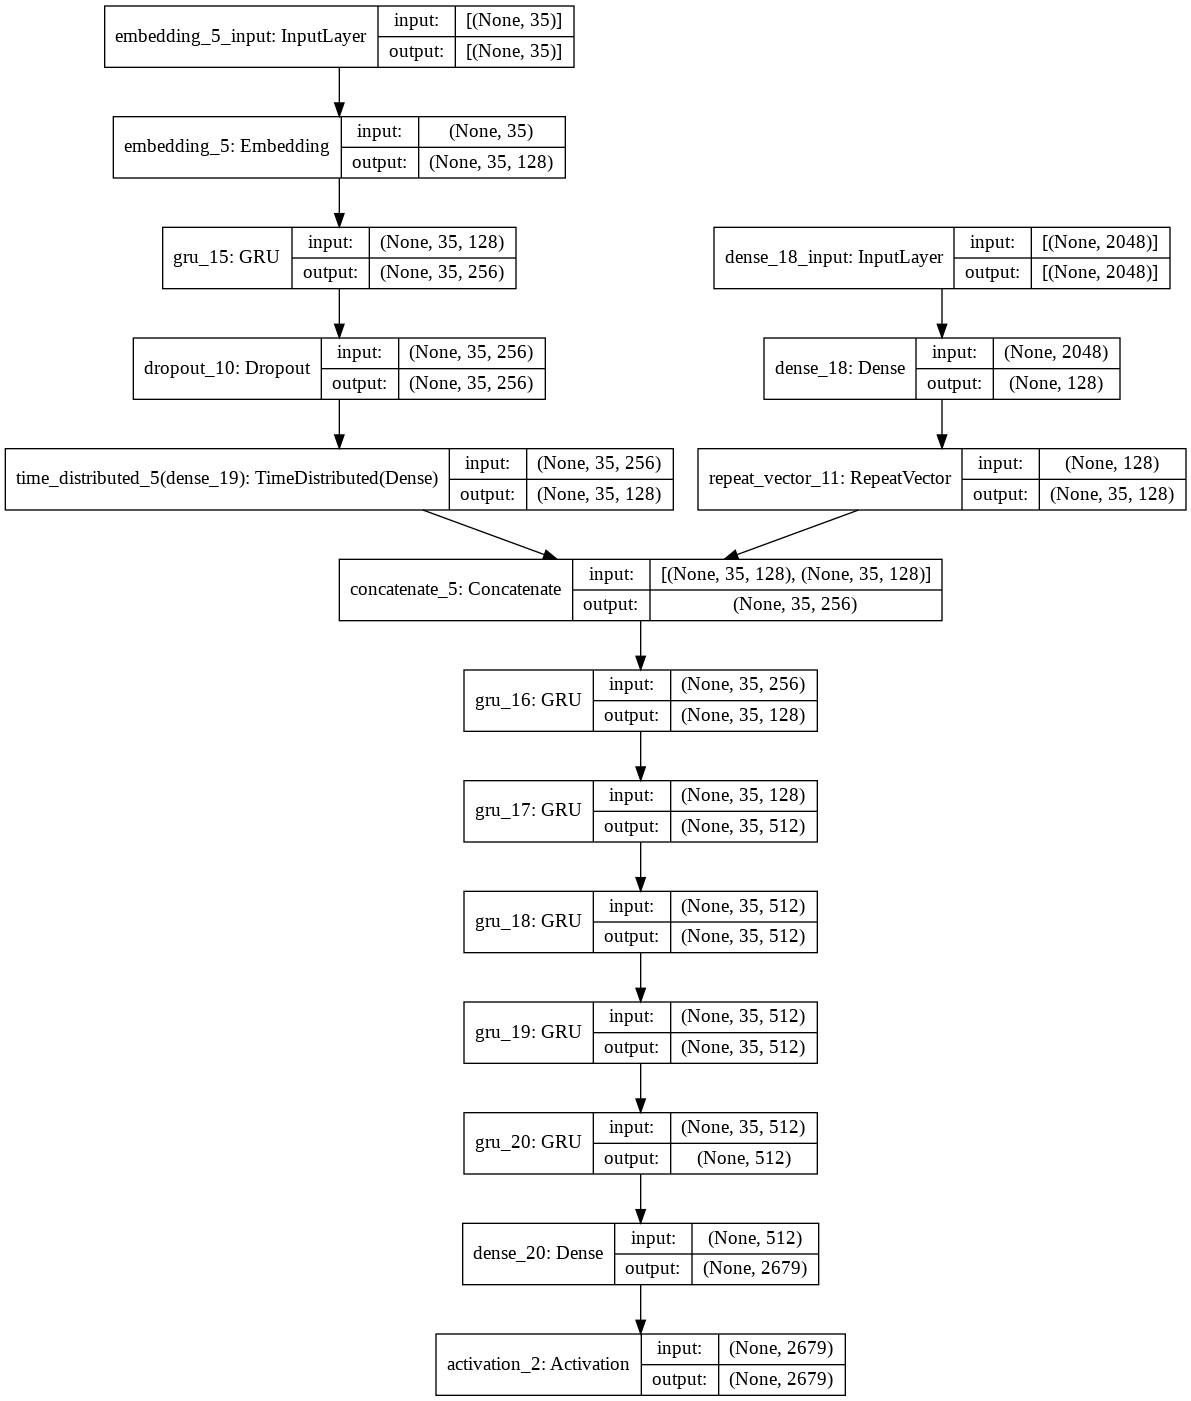

In [117]:
# from keras.utils import plot_model
plot_model(model,to_file='model.png', show_shapes=True)

In [120]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [121]:
## Training the model 

total_timetaken = []
time_callback = TimeHistory()

history = model.fit([X, y_in], y_out, batch_size=256, epochs=5, callbacks=[time_callback])
total_timetaken.append(time_callback.times)
print('Training Done')
model_1_history = history

Epoch 1/5
238/238 [==============================] - 1845s 8s/step - loss: 5.3231 - accuracy: 0.1470
Epoch 2/5
238/238 [==============================] - 1835s 8s/step - loss: 5.2621 - accuracy: 0.1475
Epoch 3/5
238/238 [==============================] - 1832s 8s/step - loss: 5.2653 - accuracy: 0.1475
Epoch 4/5
238/238 [==============================] - 1835s 8s/step - loss: 5.2655 - accuracy: 0.1482
Epoch 5/5
238/238 [==============================] - 1851s 8s/step - loss: 5.2649 - accuracy: 0.1467
Training Done


In [122]:
## Creating the Inverse dictionary for works and it's corresponding numbers.
## This is used to retrieve the word against the number predicted based on Probabilistic model

inv_dict = {v:k for k, v in new_dict.items()}

In [123]:
## Saving the inverse dictionary for future reference
from pickle import dump
dump(inv_dict,open('inv_dict1500.p','wb'))

In [124]:
## Saving the model.h5 file for offline usage
model.save('trainedmodel1500.h5')

In [125]:
## Saving the model's weights
model.save_weights('mine_model_weights.h5')

In [126]:
## Saving new_dict in the form of numpy dictionary
np.save('vocab.npy', new_dict)

In [56]:
## Function for accessing images from the test data

def getImage(x):
    
    test_img_path = list_of_images[x]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, (224,224))
    test_img = np.reshape(test_img, (1,224,224,3))

    return test_img

In [134]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [135]:
## 	Plotting the loss	and	accuracy history	graphs

def plot_loss_acc_graph(history):

  metrics = ['loss', 'accuracy']
  for metric in metrics:
    train_metrics = history.history[metric]
    val_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

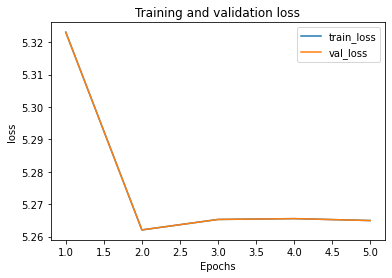

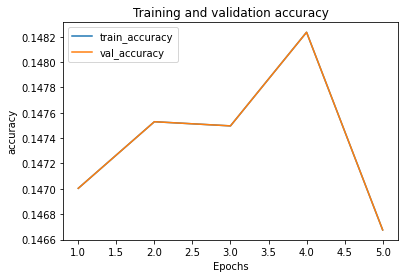

Total Time taken for Training 'model_1' model :  9197.200782775879


In [136]:
plot_loss_acc_graph(model_1_history)
print("Total Time taken for Training 'model_1' model : ", sum(total_timetaken[0]))

## 6.	Model	Evaluation

Predicting captions for 5 random images in range 1500 to 6000


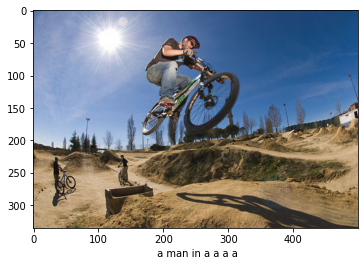

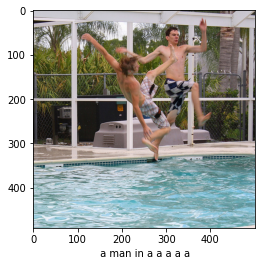

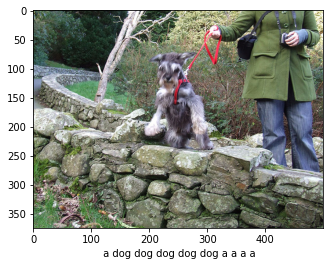

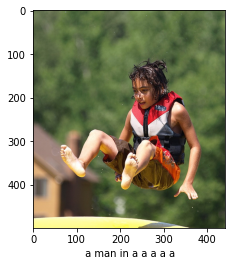

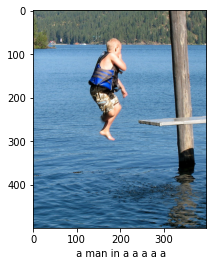

In [60]:
## Predicting captions for 5 random images in range 1500 to 6000
for i in range(5):
    
    no = np.random.randint(0,1500,(1,1))[0,0]
    test_feature = model_emb.predict(getImage(no)).reshape(1,2048)
    test_img_path = list_of_images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    text_inp = ['startseq']
    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        sampled_word = inv_dict[prediction]
        
        if sampled_word == 'endseq':
            break
        caption = caption + ' ' + sampled_word
            
        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)